# Fighting Bias

In this notebook, we present the work done to debias the Income Level prediction on the 2 following protected attributes: Sex (understood as 'M' and 'F') and Race (understood as 'Black' and 'White').

The work is organised as follows:
1. Load the data
2. Train the given XGBoost model, according to the default parameters
3. Make a bias evaluation, this means computing the p-rule and plotting the score distributions according to values of the protected attributes
4. Apply the XGBoost method 
5. Apply the Wrapper method 
6. Apply the Adversarial method 

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

SEED = 7
np.random.seed(SEED)
sns.set(style="white", palette="muted", color_codes=True, context="talk")
%matplotlib inline

In [2]:
from __future__ import division
from collections import defaultdict

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout, Concatenate
from keras.models import Model

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from random import seed, shuffle
import xgboost as xgb

Using TensorFlow backend.


In [3]:
from data_loader import *

In [4]:
data_path = "../data/adult.data.csv"

## 1. Load the data


In [5]:
X,y,Z =load_ICU_data(data_path)

features X:  30940  samples,  94  attributes
targets y:  30940  samples
sensitives Z:  30940  samples,  2  attributes


In [6]:
X, y, Z = add_index(X,y,Z)

In [7]:
Z.head()

race  sex
Sample_ID           
M_W_1         1    1
M_W_2         1    1
M_W_3         1    1
M_B_4         0    1
F_B_5         0    0

We extract the protected attributes <br>
Before we had only age so that fine but now we need to add Nationality: go back to the original file: predsolv_selection.csv and query nationality info based on wf_id

In [8]:
# Getting the 'protected' attributes
sex_column = 'sex'
race_column = 'race'
prediction_threshold = 0.5

In [9]:
# Divide train and test
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, stratify=y, random_state=SEED)

## 2. Run the XGBoost model
This model is called unaware model, because it tries to perform the task without any knowledge of the debiasing goal.
Run or load here the best XGBoost model as <b>bst</b> and make predictions on the test set

In [10]:
# Create your train and test matrices to feed the model
dtrain = xgb.DMatrix(pd.concat([X_train, Z_train['sex']], axis=1), label=y_train)
dtest = xgb.DMatrix(pd.concat([X_test, Z_test['sex']], axis=1), label=y_test)

/Users/taaleem1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [11]:
# Default parameters
param = {
    'max_depth':6,
    'learning_rate':0.3,
    'gamma':0,
    'reg_lambda':1,
    'scale_pos_weight':1,
    'silent':1}

num_round=100 # training iterations

In [12]:
# Train your model with the best parameters
bst = xgb.train(param, dtrain, num_round)

We will make the predictions with the unaware model in order to evaluate the strength of our debiasing

In [13]:
# Compute the predictions for the test set with the method of your choice
#preds = np.exp(bst.predict(dtest)) -1
unaware_preds = bst.predict(dtest)

## 3. Evaluate bias in the unaware model
We will compute here the performance of the model in terms of Precision-Recall Area under the curve, plot the score distributions with respect to the protected attributes value and finally compute the p-rule

In [14]:
# The performance method will compute all the desired metrics to evaluate how skilful our model is.
# Contains PR-AUC score (closest to 1 is best), Accuracy (closest to 100% is best) and plots the PR-curve
def performance(true_labels, predictions):
    # Computation of Precision = True positives / (True positives + False positives) --> Positive Predictive value
    # Computation of Recall = True positives / (True positives + False negatives) --> Same as sensitivity TPR
    precision, recall, thresholds = precision_recall_curve(true_labels, predictions)
    print("PR AUC: ", 100*auc(recall, precision))
    print("Accuracy: ",100*accuracy_score(true_labels, (predictions>prediction_threshold)))
    plt.plot([0,1], [0.5,0.5], linestyle='--')
    plt.plot(recall, precision, marker='.')
    plt.show()

PR AUC:  81.87967695268064
Accuracy:  86.92630898513252


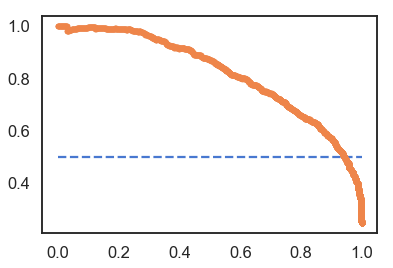

In [15]:
performance(y_test, unaware_preds)

In order to plot the distributions depending on Nationality and Age, the protected attributes should correspond to features 'Nationality' (values 'CH', 'EU', 'Foreign') and 'Age' (values 'young' and 'adult').

In [16]:
# Method to plot the score distributions for different age and nationality categories.
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    tmp_Z = Z.copy()
    # Retreive the number of protected attributes to visualise
    protected_attributes = Z.columns
    # Create accordingly the number of subplots
    fig, axes = plt.subplots(1, len(protected_attributes), figsize=(10, 6), sharey=True)
    fig.patch.set_facecolor('tab:gray')
    # We will now fill the plots for each attributes (idx gives index in subplot and attr the column to use in Z)
    for idx, attr in enumerate(protected_attributes):
        # For a given attribute in Z, we need to plot a curve per possible value
        for attr_val in tmp_Z[attr].unique():
            # Create the curve of scores (in y) filtered by the attribute value (Z[attr] == attr_val)
            ax = sns.distplot(y[tmp_Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,}, #Styling
                              label= str(attr_val), #Add the label of current value in the legend
                              ax=axes[idx] if len(protected_attributes) >1 else axes) # Sepcify in which subplot to plot
        # Scores are only between 0 and 1
        ax.set_xlim(0,1)
        ax.set_yticks([])
        ax.set_title("protected attibute: {}".format(attr)) # Display as title which protected attributes is concerned
        if idx == 0:
            ax.set_ylabel('prediction distribution') # put on the common scale the value of y-axis, distribution
        # set to the x axis which attribute is concerned also
        ax.set_xlabel(r'$P({{Income Level}}|z_{{{}}})$'.format(attr))
        ax.legend(bbox_to_anchor=(0.5 , -0.25), fontsize='large')
        
    # If plotting during training, we can see the evolution of metrics    
    if iteration:
        fig.text(1.0, 0.9, "Training iteration "+str(iteration), fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       "- PR AUC: "+ str(val_metrics['PR AUC']),
                                       "- Accuracy:"+str(val_metrics['Accuracy'])]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     ["- "+str(attr)+": "+str(p_rules[attr])+"-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

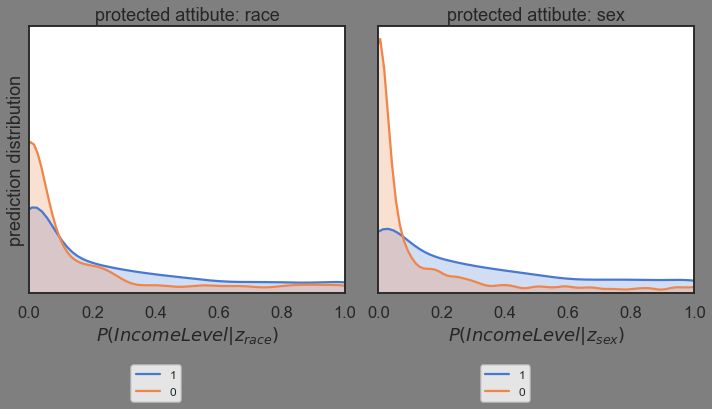

In [17]:
# We plot the distribution after applying a binary filter to split the age category, above and below 30 years old
fig = plot_distributions(unaware_preds, Z_test)

In order to compute the p-rule depending on Age, the protected attributes should have values:
- Age: adult for above 30 and young for below 30 (or any binary splitting, you can change this limit with the binary_age_threshold variable)
- Nationality: 'CH' for Swiss people and 'Foreign' for any other nationality (you can modify those categories in the filter_nationality function)

In [18]:
# Method to compute the p-rule for Age and Nationality (with 3 categories)
def p_rule(y, z, remove_missing=True, see_probs=False):
    tmp_y =  y.copy()
    tmp_z = z.copy()
    if remove_missing:
        tmp_y = tmp_y[tmp_z != 'missing']
        tmp_z = tmp_z[tmp_z != 'missing']
        
    probs = np.zeros(len(tmp_z.unique()))
    for idx, attr_val in enumerate(tmp_z.unique()):
        probs[idx] = (tmp_y[tmp_z == attr_val]).mean()
    
    if see_probs:
        print("Labels are :", z.unique())
        print("Corresponding probabilities :", probs)
    min_prob = np.nanmin(probs) #---> need to ignore nan as there can be the label nan and therefore the prob is nan
    max_prob = np.nanmax(probs)
    
    return 100* min_prob/max_prob

In [19]:
print("Classifier satisfies the following p-rules")
print("given attribute Sex", p_rule((unaware_preds>prediction_threshold), Z_test[sex_column]),"-rule")
print("given attribute Race", p_rule((unaware_preds>prediction_threshold), Z_test[race_column]),"-rule")

Classifier satisfies the following p-rules
given attribute Sex 36.518468074066874 -rule
given attribute Race 60.22233199506863 -rule


/Users/taaleem1/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## 4. Apply the XGBoost method
This post-processing method deletes the interaction of the 'Age' feature in the prediction. Nothing is done for nationality as it is not used for training.

In [20]:
#In order to compute the interactions we add a parameter to the predict function : pred_interactions=True
interactions = bst.predict(dtest, pred_interactions=True)

In [21]:
# The resulting object has shape # predictions x (# features +1) x (# features +1)
interactions.shape

(6188, 96, 96)

In [22]:
i=0
feature_names = list(X.columns) +[sex_column, 'intercept']
pd.DataFrame(interactions[i], index= feature_names , columns= feature_names)

age        fnlwgt  education_num  \
age                                -3.345445e-02 -1.755672e-03  -1.618922e-02   
fnlwgt                             -1.755659e-03  5.918030e-05   1.453552e-03   
education_num                      -1.618906e-02  1.453595e-03  -1.662227e-02   
capital_gain                       -2.552755e-03  2.467870e-04   1.730331e-03   
capital_loss                       -2.641603e-05  3.062424e-04   1.575915e-03   
hours_per_week                      1.377128e-03  2.166355e-04  -2.324283e-03   
workclass_Local-gov                -9.800866e-05  4.383642e-05  -9.751879e-06   
workclass_Never-worked              0.000000e+00  0.000000e+00   0.000000e+00   
workclass_Private                   2.959780e-04  2.764296e-04  -1.200720e-03   
workclass_Self-emp-inc              7.274747e-05  2.095141e-04  -2.766028e-06   
workclass_Self-emp-not-inc         -2.372570e-03 -8.573500e-05   2.211072e-04   
workclass_State-gov                -1.938134e-03 -8.796831e-05   1.379289e-05   
workclass_Unknown                   1.569465e-05  6.742077e-06  -2.275780e-05   
workclass_Without-pay               8.821487e-06  1.629815e-08   1.162663e-05   
education_11th                     -2.019107e-06 -4.643109e-06   0.000000e+00   
education_12th                      1.329929e-06 -1.100823e-06  -2.328306e-07   
education_1st-4th                   0.000000e+00  0.000000e+00   0.000000e+00   
education_5th-6th                  -1.407787e-05 -6.984919e-08  -1.545995e-07   
education_7th-8th                   8.702278e-06 -8.977950e-07   4.190952e-07   
education_9th                      -3.688037e-07 -2.134696e-05  -4.656613e-08   
education_Assoc-acdm                2.982467e-05  2.048523e-04  -1.145527e-07   
education_Assoc-voc                -1.173466e-05  9.436999e-05  -1.548789e-06   
education_Bachelors                 1.712702e-04  1.326716e-05  -7.612910e-05   
education_Doctorate                 0.000000e+00  0.000000e+00   0.000000e+00   
education_HS-grad                  -1.176819e-05  3.905501e-05   4.824251e-07   
education_Masters                   4.987419e-05  5.970709e-06  -2.551824e-07   
education_Preschool                 0.000000e+00  0.000000e+00   0.000000e+00   
education_Prof-school               2.886094e-04 -7.108226e-05  -2.597272e-05   
education_Some-college              2.059527e-04  8.445898e-04   8.418225e-06   
marital_status_Married-AF-spouse   -9.018928e-06  6.223097e-06   2.264977e-06   
...                                          ...           ...            ...   
country_Haiti                       0.000000e+00  0.000000e+00   0.000000e+00   
country_Holand-Netherlands          0.000000e+00  0.000000e+00   0.000000e+00   
country_Honduras                    0.000000e+00  0.000000e+00   0.000000e+00   
country_Hong                        0.000000e+00  0.000000e+00   0.000000e+00   
country_Hungary                     3.855675e-06 -1.708977e-07   0.000000e+00   
country_India                       2.287328e-06  2.169982e-07  -1.589581e-05   
country_Iran                       -2.749264e-06 -1.862645e-09  -1.639128e-07   
country_Ireland                    -1.136214e-06  1.015142e-07   5.496666e-06   
country_Italy                       1.913942e-04  1.950795e-05   1.048855e-05   
country_Jamaica                    -5.074590e-05 -4.544854e-07  -3.238581e-05   
country_Japan                       0.000000e+00  0.000000e+00   0.000000e+00   
country_Mexico                      7.628649e-05  3.090128e-06   3.562309e-06   
country_Nicaragua                  -8.638948e-06 -3.292225e-07   7.115304e-07   
country_Outlying-US(Guam-USVI-etc)  4.880130e-07 -5.274080e-06   7.450581e-09   
country_Peru                        0.000000e+00  0.000000e+00   1.862645e-09   
country_Philippines                -3.911555e-06 -5.950220e-06   2.775341e-06   
country_Poland                      1.584738e-05  1.755543e-07   2.197921e-07   
country_Portugal                    2.089888e-06 -9.313226e-10  -4.339963e-0

In [23]:
### 2nd ### 
# we identify all the columns that are related to one of the two protected attributes
bias_var = []
for f in feature_names:
    if f.startswith(sex_column) or f.startswith(race_column):
        bias_var.append(f)

In [24]:
# We need to find which indices those feature names represent, indeed the interactions object is an array (not a dataframe)
bias_idx = np.argwhere(np.isin(np.array(feature_names), bias_var))
bias_idx

array([[94]])

In [25]:
### 3rd ### 
# Now that we have the indices we can set the column and the line (as interaction matrix is symmetric) to zero (the action that kills the dependence on protected attributes)
for idx in bias_idx:
    print(idx)
    interactions[:, idx, :] = 0
    interactions[:, :, idx] =0

[94]


In [26]:
### 4th ### 
# make the new predictions, supposingly fair (with the same method as before)
#y_fair = np.exp(interactions.sum(axis=1).sum(axis=1)) -1
y_fair = interactions.sum(axis=1).sum(axis=1)

PR AUC:  81.80567501657758
Accuracy:  86.8939883645766


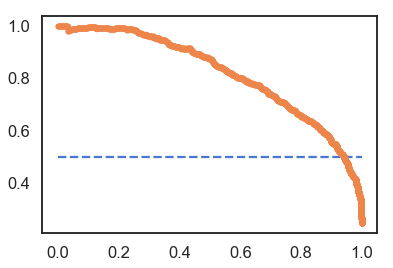

In [27]:
### 5th ### 
# compute the performance and compare to previous values
performance(y_test, y_fair)

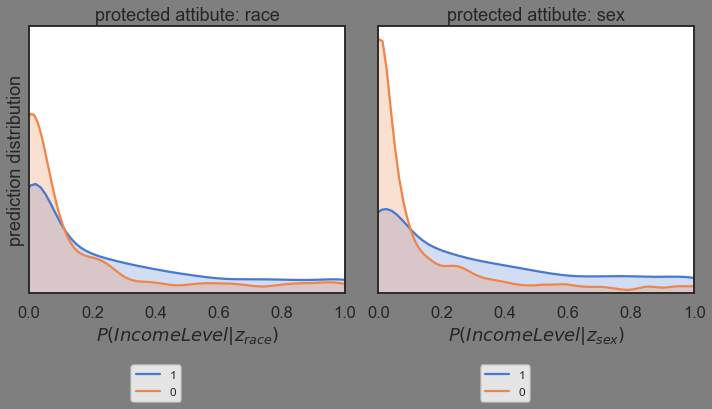

In [28]:
_ = plot_distributions(y_fair, pd.DataFrame(Z_test), fname=None)

In [29]:
print("Classifier satisfies the following p-rules")
print("given attribute Sex", p_rule((y_fair>prediction_threshold), Z_test[sex_column]),"-rule")
print("given attribute Race", p_rule((y_fair>prediction_threshold), Z_test[race_column]),"-rule")

Classifier satisfies the following p-rules
given attribute Sex 38.61177565124934 -rule
given attribute Race 60.40220355902654 -rule


### Evaluate the Cost & Benefits

In [30]:
# This functions retreives the IDs that went from 0 to 1 and in reverse.
def get_swapped_ids(fair_preds, unaware_preds, threshold=prediction_threshold):
    fair = (fair_preds >= threshold)
    unaware = (unaware_preds >= threshold)
    new_0 = np.where(fair < unaware)
    new_1 = np.where(fair > unaware)
    return new_0[0], new_1[0]

In [31]:
new_0, new_1 = get_swapped_ids(y_fair, unaware_preds)

In [32]:
print("Number of previously 0 now 1 ", len(new_1))
print("Number of previsouly 1, now 0", len(new_0))

Number of previously 0 now 1  7
Number of previsouly 1, now 0 27


In [33]:
# We compute here the percentage of datasamples that we swapped
(len(new_0) + len(new_1))/len(y_test)

0.005494505494505495

## 5. Apply the Wrapper method
We have here our adversarial set-up for Disparate Impact. The difference is that the classifier gets as input the data as well as the prediction from the XGBoost model: unaware_preds. <br>

Get the predictions for the train set with the XGBoost model, and include them together with the test predictions in a dataframe.

In [52]:
unaware_train_preds = pd.DataFrame(bst.predict(dtrain), index=X_train.index, columns=['xgboost'])

In [53]:
unaware_test_preds = pd.DataFrame(unaware_preds, index=X_test.index, columns=['xgboost'])

In [54]:
unaware_pred = pd.concat([ unaware_train_preds, unaware_test_preds ])

In [55]:
# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
def plot_metrics(val_metrics, fairness_metrics):
    fig, axes = plt.subplots(1,2, figsize=(15, 5))
    fig.patch.set_facecolor('tab:gray')
    ax = val_metrics.plot(ylim=(0,100), ax=axes[0])
    ax = fairness_metrics.plot(ylim=(0,100), ax=axes[1])
    fig.tight_layout()
    plt.axhline(y=80, xmin=0, xmax=50, color= 'r')
    plt.show()
    return fig

In [57]:
class Wrapper(object):
    def __init__(self, n_unprotected, n_protected, lambdas):
        self.lambdas = lambdas
        
        unprotected = Input(shape=(n_unprotected,))
        protected = Input(shape=(n_protected,))
        unaware_pred = Input(shape=(1,))
        y_pred = Input(shape=(1,))
        
        #Initialize
        clf_net = self._create_clf_net([unprotected, protected, unaware_pred])
        adv_net = self._create_adv_net(y_pred, n_protected)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv([unprotected, protected, unaware_pred], clf_net, adv_net)
        self._adv = self._compile_adv([unprotected, protected, unaware_pred], clf_net, adv_net, n_protected)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        concat_layer = Concatenate()(inputs)
        dense1 = Dense(32, activation='relu')(concat_layer)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        #Predict only income level
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=inputs, outputs=[outputs])
        
    def _create_adv_net(self, y_pred, n_protected):
        dense1 = Dense(32, activation='relu')(y_pred)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        #Predict for the number of sensitive features (Z)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_protected)]
        return Model(inputs=[y_pred], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=inputs, outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        #Weigths to implement Loss_y - lambda * loss_z
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']* (len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_protected):
        #Make model that take input X, and outputs prediction of sensitive 
        #attributes (output of adv_net, when given the output of classifier
        # ie. clf_net(X))
        adv = Model(inputs=inputs, outputs=adv_net(clf_net(inputs)))
        #We need to freeze the layers of the classifier net as we train only adv
        self._trainable_clf_net(False)
        #And train only the adversarial
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_protected, optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        #Function computing the proportion of labels in the given dataset
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    #--- Usable functions ---
    def pretrain(self, x, y, z, unaware_pred, epochs=10, verbose=0):
        #Pre-train both networks !
        self._trainable_clf_net(True)
        #Train classifier on entire dataset
        self._clf.fit([x.values, z.values, unaware_pred.values], y.values, epochs=epochs, verbose=verbose)
        #Freeze classifier
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        #Train adversarial with the sensitive info and class_weight:
        """class_weight: Optional dictionary mapping class indices (integers) to a weight (float) value, 
        used for weighting the loss function (during training only). 
        This can be useful to tell the model to "pay more attention" to samples from an under-represented class."""
        self._adv.fit([x.values, z.values, unaware_pred.values], np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, unaware_pred, validation_data=None, T_iter=250, batch_size=128,
            show= True, save_figs=False):
        #Training of the 2 NN in turns.
        n_protected = z.shape[1]
        if validation_data is not None:
            #Just unwrapp input
            x_val, y_val, z_val, unaware_pred_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        #Storage of values
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            #### PREDICT function but at every training step (to see evolution)
            if validation_data is not None:
                #Make the classifier prediction for y
                y_pred = pd.Series(self._clf.predict([x_val, z_val, unaware_pred_val]).ravel(), index=y_val.index)
                #print(y_pred.map(lambda x: round(x,1)).value_counts())
                
                #Computed values for different metrics
                precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
                self._val_metrics.loc[idx, 'PR AUC'] = 100*auc(recall, precision)
                self._val_metrics.loc[idx, 'Accuracy'] = 100*accuracy_score(y_val, (y_pred>prediction_threshold))
                self._fairness_metrics.loc[idx, 'Sex'] = p_rule(y_pred, z_val[sex_column])
                self._fairness_metrics.loc[idx, 'Race'] = p_rule(y_pred, z_val[race_column])

                #Plot the curves with metrics
                if show:
                    display.clear_output(wait=True)
                    plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                       self._fairness_metrics.loc[idx],
                                       fname='output/'+str(idx+1)+'.png' if save_figs else None)
                    plt.show(plt.gcf())
                
            
            # train adverserial
            #Freeze Classifier
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            #Do only one epoch
            self._adv.fit([x.values, z.values, unaware_pred.values], np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            #Free adversarial
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            #Get a random batch
            indices = np.random.permutation(len(x))[:batch_size]
            #Override the batch selection to be sure that we have positive samples
            #indices = sample_idx(y, z, len(x), batch_size)
            self._clf_w_adv.train_on_batch([x.values[indices], z.values[indices], unaware_pred.values[indices]], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_protected),
                                           class_weight=class_weight_clf_w_adv)
        return y_pred, self._val_metrics, self._fairness_metrics

In [86]:
# initialise FairClassifier
wrapper = Wrapper(n_unprotected=X_train.shape[1], n_protected=Z_train.shape[1], lambdas=[30, 50])

In [87]:
# pre-train both adverserial and classifier networks
wrapper.pretrain(X_train, y_train, Z_train, unaware_train_preds, verbose=0, epochs=5)

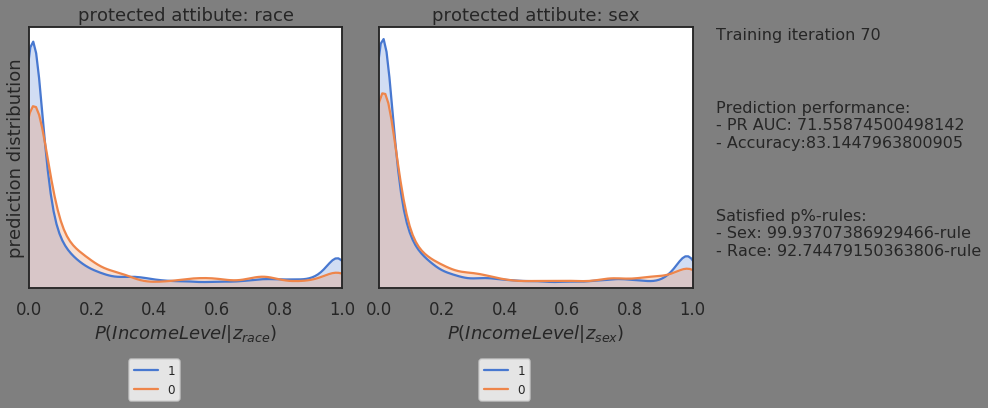

In [88]:
wrap_preds, wrap_val, wrap_fairness= wrapper.fit(X_train, y_train, Z_train, unaware_train_preds,
                validation_data=(X_test, y_test, Z_test, unaware_test_preds), T_iter= 70, show=True, save_figs=False)

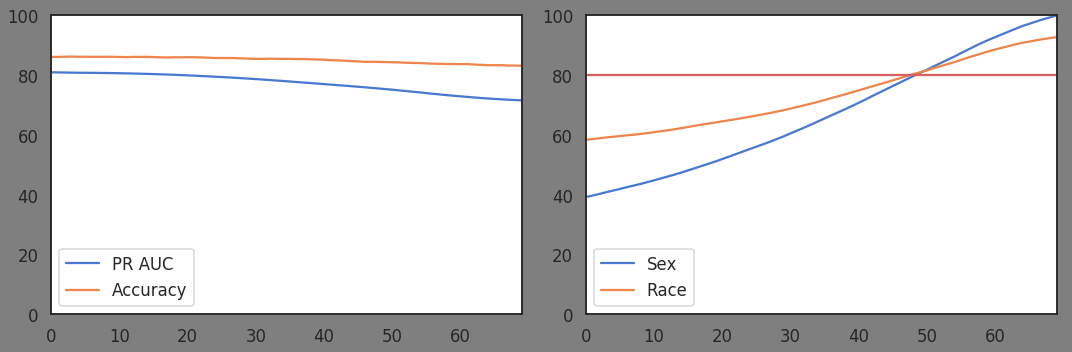

In [89]:
_= plot_metrics(wrap_val, wrap_fairness)

PR AUC:  0.7155874500498142
Accuracy:  83.1447963800905


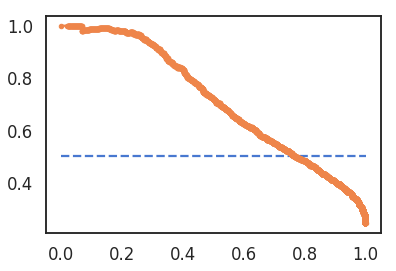

In [90]:
performance(y_test, wrap_preds)

In [91]:
print("Classifier satisfies the following p-rules")
print("given attribute Sex", p_rule((wrap_preds>prediction_threshold), Z_test[sex_column]),"-rule")
print("given attribute Race", p_rule((wrap_preds>prediction_threshold), Z_test[race_column]),"-rule")

Classifier satisfies the following p-rules
given attribute Sex 98.2792191746973 -rule
given attribute Race 91.43743260193051 -rule


/opt/conda/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [92]:
new_0, new_1 = get_swapped_ids(wrap_preds, unaware_preds)

In [93]:
print("Number of previously 0, now 1 ", len(new_1))
print("Number of previsouly 1, now 0", len(new_0))

Number of previously 0, now 1  212
Number of previsouly 1, now 0 440


In [94]:
# We compute here the percentage of datasamples that we swapped
(len(new_0) + len(new_1))/len(y_test)

0.10536522301228184

## 6. Apply the Adversarial method  (Disparate impact only)

In [67]:
class FairClassifier(object):
    def __init__(self, n_unprotected, n_protected, lambdas):
        self.lambdas = lambdas
        
        unprotected = Input(shape=(n_unprotected,))
        protected = Input(shape=(n_protected,))
        y_pred = Input(shape=(1,))
        
        #Initialize
        clf_net = self._create_clf_net([unprotected, protected])
        adv_net = self._create_adv_net(y_pred, n_protected)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv([unprotected, protected], clf_net, adv_net)
        self._adv = self._compile_adv([unprotected, protected], clf_net, adv_net, n_protected)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        concat_layer = Concatenate()(inputs)
        dense1 = Dense(32, activation='relu')(concat_layer)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        #Predict only income level
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=inputs, outputs=[outputs])
        
    def _create_adv_net(self, y_pred, n_protected):
        dense1 = Dense(32, activation='relu')(y_pred)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        #Predict for the number of sensitive features (Z)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_protected)]
        return Model(inputs=[y_pred], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=inputs, outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        #Weigths to implement Loss_y - lambda * loss_z
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']* (len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_protected):
        #Make model that take input X, and outputs prediction of sensitive 
        #attributes (output of adv_net, when given the output of classifier
        # ie. clf_net(X))
        adv = Model(inputs=inputs, outputs=adv_net(clf_net(inputs)))
        #We need to freeze the layers of the classifier net as we train only adv
        self._trainable_clf_net(False)
        #And train only the adversarial
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_protected, optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        #Function computing the proportion of labels in the given dataset
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    #--- Usable functions ---
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        #Pre-train both networks !
        self._trainable_clf_net(True)
        #Train classifier on entire dataset
        self._clf.fit([x.values, z.values], y.values, epochs=epochs, verbose=verbose)
        #Freeze classifier
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        #Train adversarial with the sensitive info and class_weight:
        """class_weight: Optional dictionary mapping class indices (integers) to a weight (float) value, 
        used for weighting the loss function (during training only). 
        This can be useful to tell the model to "pay more attention" to samples from an under-represented class."""
        self._adv.fit([x.values, z.values], np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            show= True, save_figs=False):
        #Training of the 2 NN in turns.
        n_protected = z.shape[1]
        if validation_data is not None:
            #Just unwrapp input
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        #Storage of values
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            #### PREDICT function but at every training step (to see evolution)
            if validation_data is not None:
                #Make the classifier prediction for y
                y_pred = pd.Series(self._clf.predict([x_val, z_val]).ravel(), index=y_val.index)
                print(y_pred.map(lambda x: round(x,1)).value_counts())
                
                #Computed values for different metrics
                precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
                self._val_metrics.loc[idx, 'PR AUC'] = 100*auc(recall, precision)
                self._val_metrics.loc[idx, 'Accuracy'] = 100*accuracy_score(y_val, (y_pred>prediction_threshold))
                self._fairness_metrics.loc[idx, 'Sex'] = p_rule(y_pred, z_val[sex_column])
                self._fairness_metrics.loc[idx, 'Race'] = p_rule(y_pred, z_val[race_column])

                #Plot the curves with metrics
                if show:
                    display.clear_output(wait=True)
                    plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                       self._fairness_metrics.loc[idx],
                                       fname='output/'+str(idx+1)+'.png' if save_figs else None)
                    plt.show(plt.gcf())
                
            
            # train adverserial
            #Freeze Classifier
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            #Do only one epoch
            self._adv.fit([x.values, z.values], np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            #Free adversarial
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            #Get a random batch
            indices = np.random.permutation(len(x))[:batch_size]
            #Override the batch selection to be sure that we have positive samples
            #indices = sample_idx(y, z, len(x), batch_size)
            self._clf_w_adv.train_on_batch([x.values[indices], z.values[indices]], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_protected),
                                           class_weight=class_weight_clf_w_adv)
        return y_pred, self._val_metrics, self._fairness_metrics

In [131]:
# initialise FairClassifier
clf = FairClassifier(n_unprotected=X_train.shape[1], n_protected=Z_train.shape[1], lambdas=[30, 50])

# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

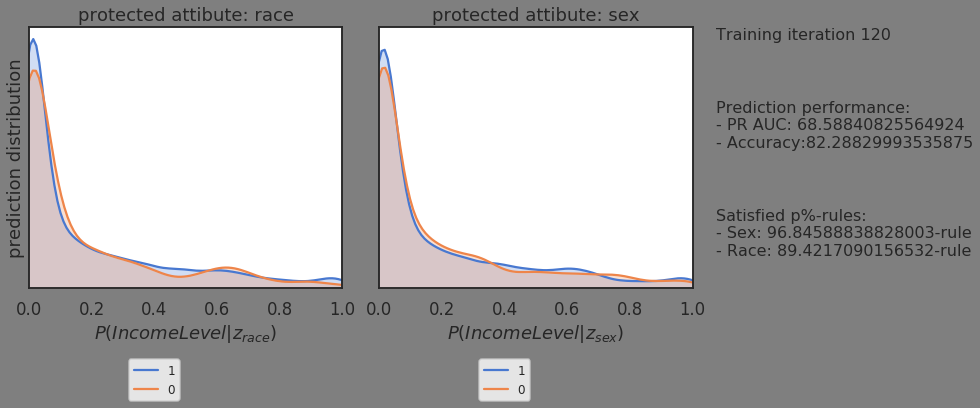

In [132]:
fair_preds, val_metrics, fairness_metrics = clf.fit(X_train, y_train, Z_train, 
                validation_data=(X_test, y_test, Z_test), T_iter= 120, show=True, save_figs=False)

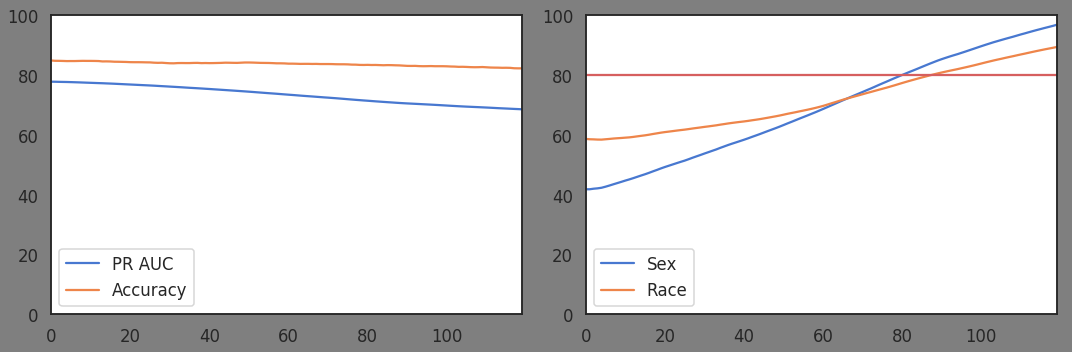

In [133]:
_= plot_metrics(val_metrics[:120], fairness_metrics[:120])

PR AUC:  0.6858840825564924
Accuracy:  82.28829993535875


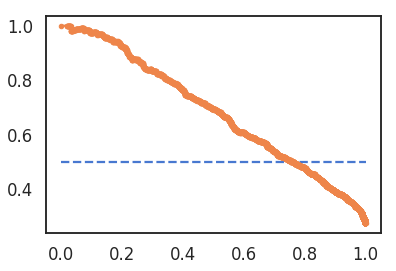

In [134]:
performance(y_test, fair_preds)

In [135]:
print("Classifier satisfies the following p-rules")
print("given attribute Sex", p_rule((fair_preds>prediction_threshold), Z_test[sex_column]),"-rule")
print("given attribute Race", p_rule((fair_preds>prediction_threshold), Z_test[race_column]),"-rule")

Classifier satisfies the following p-rules
given attribute Sex 95.22993324018009 -rule
given attribute Race 92.43116036768107 -rule


/opt/conda/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [136]:
new_0, new_1 = get_swapped_ids(fair_preds, unaware_preds)

In [137]:
print("Number of previously 0, now 1:", len(new_1))
print("Number of previsouly 1, now 0:", len(new_0))

Number of previously 0, now 1: 142
Number of previsouly 1, now 0: 591


In [138]:
# We compute here the percentage of datasamples that we swapped
(len(new_0) + len(new_1))/len(y_test)

0.11845507433742727